In [22]:
import json
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString, shape
import networkx as nx

In [23]:
buildings_file = "./input_files/buildings.geojson"
roads_file = "./input_files/roads.json"

In [24]:
with open(buildings_file, 'r') as file:
     city = json.load(file)

In [25]:
centroids = []
building_ids = []  # List to store building IDs
buildings = city['features']
for building in buildings:
    coordinates = building['geometry']['coordinates'][0]
    building_polygon = Polygon(coordinates)
    centroid = building_polygon.centroid
    centroids.append(centroid)
    building_ids.append(building['id'])  # Extract building ID

In [26]:
import json
from pathlib import Path
from shapely.geometry import Polygon, Point, shape

def process_geojson(x, y, diff):
    """
    Processes a GeoJSON file to find roads that have at least one node within a specified polygon.
    
    Parameters:
    x (float): The x-coordinate of the center of the selection box.
    y (float): The y-coordinate of the center of the selection box.
    diff (float): The half-width of the selection box.
    
    Returns:
    str: The file path of the output GeoJSON file containing the selected roads.
    """
    diff += 2*diff
    # Define the selection box (polygon)
    selection_box = Polygon([
        [x + diff, y - diff],
        [x - diff, y - diff],
        [x - diff, y + diff],
        [x + diff, y + diff]
    ])

    # Define input and output file paths
    geojson_file = Path("./input_files/roads.json").resolve()
    output_file = Path('./input_files/output_roads.geojson').resolve()
    
    # Initialize a list to store the roads in the region
    roads_in_region = []

    # Read the GeoJSON file
    with open(geojson_file, 'r') as file:
        roads = json.load(file)
        line_features = [feature for feature in roads['features'] if feature['geometry']['type'] == 'LineString']

        # Check each road feature
        for feature in line_features:
            road_shape = shape(feature['geometry'])
            # Check if any node of the road is inside the selection box
            if any(selection_box.contains(Point(coord)) for coord in road_shape.coords):
                roads_in_region.append(feature)

    # Create a new GeoJSON structure with the selected roads
    output_geojson = {
        "type": "FeatureCollection",
        "features": roads_in_region
    }

    # Write the selected roads to the output file
    with open(output_file, 'w') as outfile:
        json.dump(output_geojson, outfile)

    return output_file

In [27]:
road_geojson = process_geojson(-73.61038745537758, 45.484399882086215, 0.001)

In [28]:
with open(road_geojson, 'r') as file:
     roads = json.load(file)

In [29]:
line_features = [feature for feature in roads['features'] if feature['geometry']['type'] == 'LineString']

# Create a list of LineString objects and their properties
lines = []
for feature in line_features:
    # Create a LineString from coordinates
    linestring = LineString(feature['geometry']['coordinates'])
    lines.append(linestring)

In [30]:
cleaned_lines = []
for line in lines:
    coords = list(line.coords)
    cleaned_line = LineString([coords[0], coords[-1]])
    cleaned_lines.append(cleaned_line)

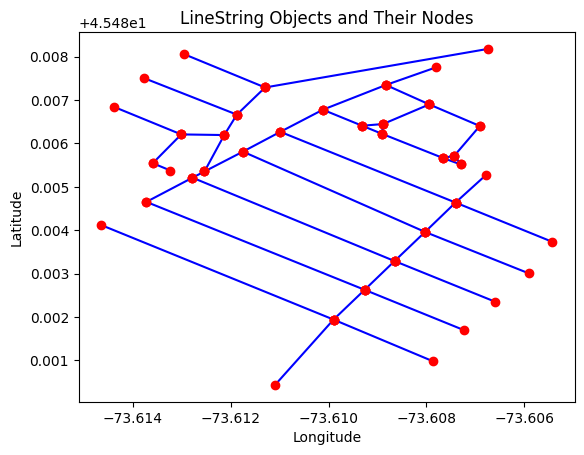

In [31]:
fig, ax = plt.subplots()
    
for line in cleaned_lines:
    # Extract the x and y coordinates of the LineString
    x, y = line.xy
    
    # Plot the LineString
    ax.plot(x, y, color='blue')
    
    # Plot the nodes (points)
    for coord in line.coords:
        point = Point(coord)
        ax.plot(point.x, point.y, 'ro')  # 'ro' for red circles

ax.set_title('LineString Objects and Their Nodes')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [32]:
closest_roads = []
unique_roads_set = set()

# Loop through each centroid
for centroid in centroids:
    min_distance = float('inf')  # Start with a large number to ensure any real distance is smaller
    closest_road = None
    
    # Loop through each road and calculate the distance to the current centroid
    for line in cleaned_lines:
        distance = line.distance(centroid)
        # Check if the current road is closer than the ones previously checked
        if distance < min_distance:
            min_distance = distance
            closest_road = line

    # Add the closest road to the list if it's not already added
    if closest_road and closest_road.wkt not in unique_roads_set:
        unique_roads_set.add(closest_road.wkt)
        closest_roads.append(closest_road)

Text(0, 0.5, 'Latitude')

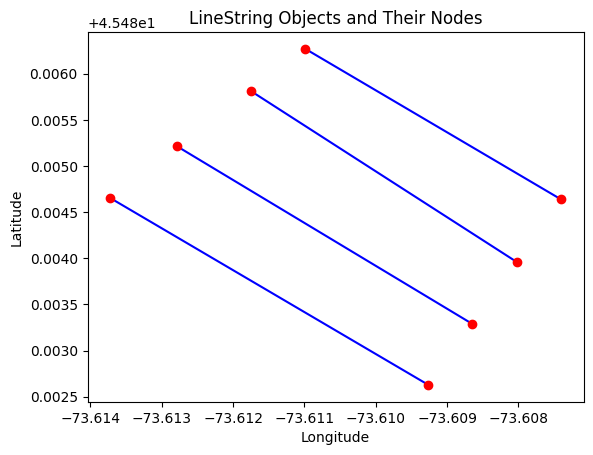

In [33]:
fig, ax = plt.subplots()
    
for line in closest_roads:
    # Extract the x and y coordinates of the LineString
    x, y = line.xy
    
    # Plot the LineString
    ax.plot(x, y, color='blue')
    
    # Plot the nodes (points)
    for coord in line.coords:
        point = Point(coord)
        ax.plot(point.x, point.y, 'ro')  # 'ro' for red circles

ax.set_title('LineString Objects and Their Nodes')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [34]:
def find_nearest_point_on_line(point, line):
    return line.interpolate(line.project(point))

# List to store the nearest points
nearest_points = []

# Find the nearest point on each closest road for each centroid
for centroid in centroids:
    # Find the closest road for this centroid
    min_distance = float('inf')
    closest_road = None
    for road in closest_roads:
        distance = centroid.distance(road)
        if distance < min_distance:
            min_distance = distance
            closest_road = road

    # Find the nearest point on the closest road
    if closest_road:
        nearest_point = find_nearest_point_on_line(centroid, closest_road)
        nearest_points.append(nearest_point)

In [35]:
len(nearest_points)

57

In [36]:
def break_down_roads(closest_roads, nearest_points_list):
    new_segments = []
    for road in closest_roads:
        # Get coordinates of the road
        coords = list(road.coords)
        # Find all nearest points for this road
        points_on_road = [point for point in nearest_points_list if road.distance(point) < 0.000000001]
        # Sort nearest points along the road
        sorted_points = sorted(points_on_road, key=lambda point: road.project(point))
        # Add the start node to the sorted points
        sorted_points.insert(0, Point(coords[0]))
        # Add the end node to the sorted points
        sorted_points.append(Point(coords[-1]))
        # Create new segments
        for i in range(len(sorted_points) - 1):
            segment = LineString([sorted_points[i], sorted_points[i + 1]])
            new_segments.append(segment)
    return new_segments

# Create new segments
new_segments = break_down_roads(closest_roads, nearest_points)

len(new_segments)

61

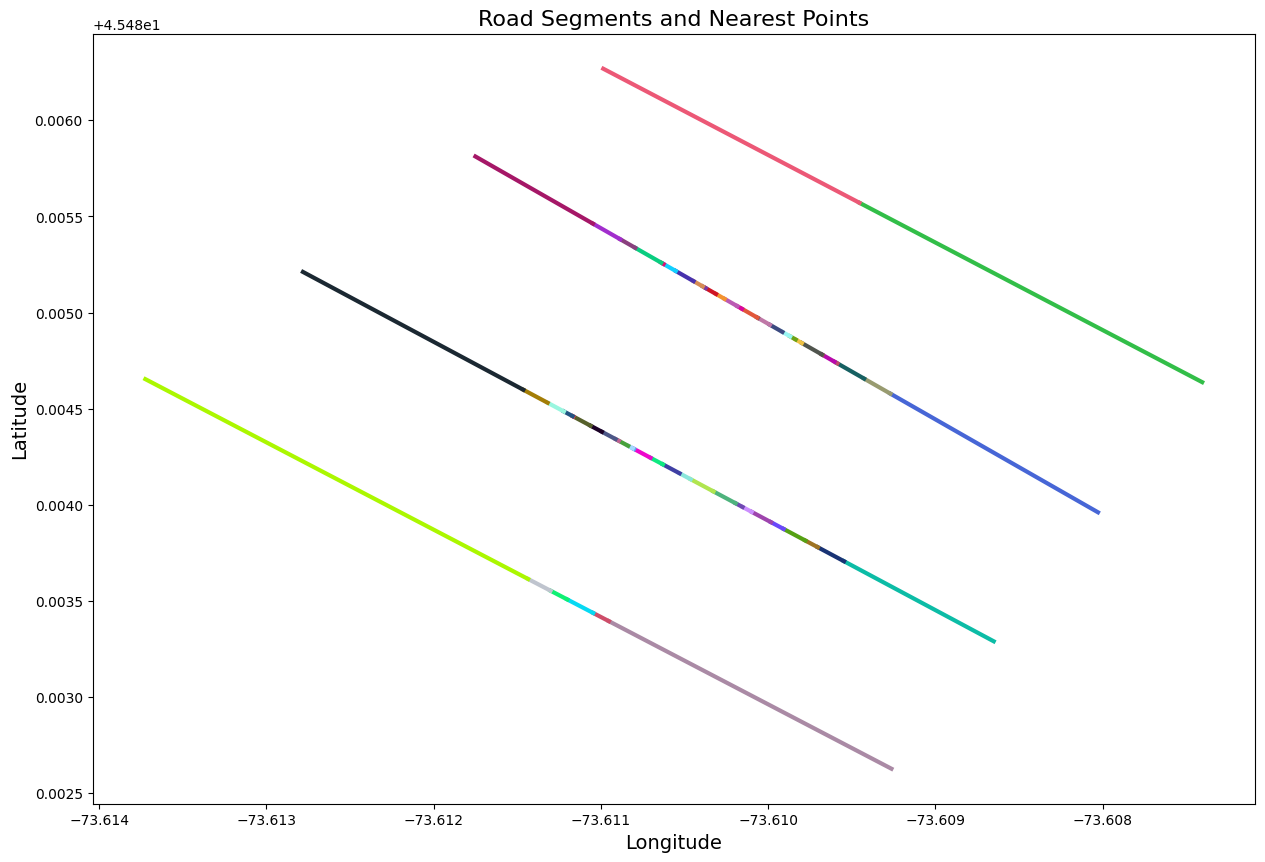

In [37]:
import random
def random_color():
    return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
fig, ax = plt.subplots(figsize=(15, 10))  # Increase the figure size

# Plot the segments with random colors
for i, segment in enumerate(new_segments):
    x, y = segment.xy
    ax.plot(x, y, color=random_color(), linewidth=3, label=f'Segment {i+1}')  # Increase the linewidt

ax.set_title('Road Segments and Nearest Points', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.show()

In [38]:
cleaned_lines = [line for line in cleaned_lines if line not in closest_roads]
cleaned_lines.extend(new_segments)

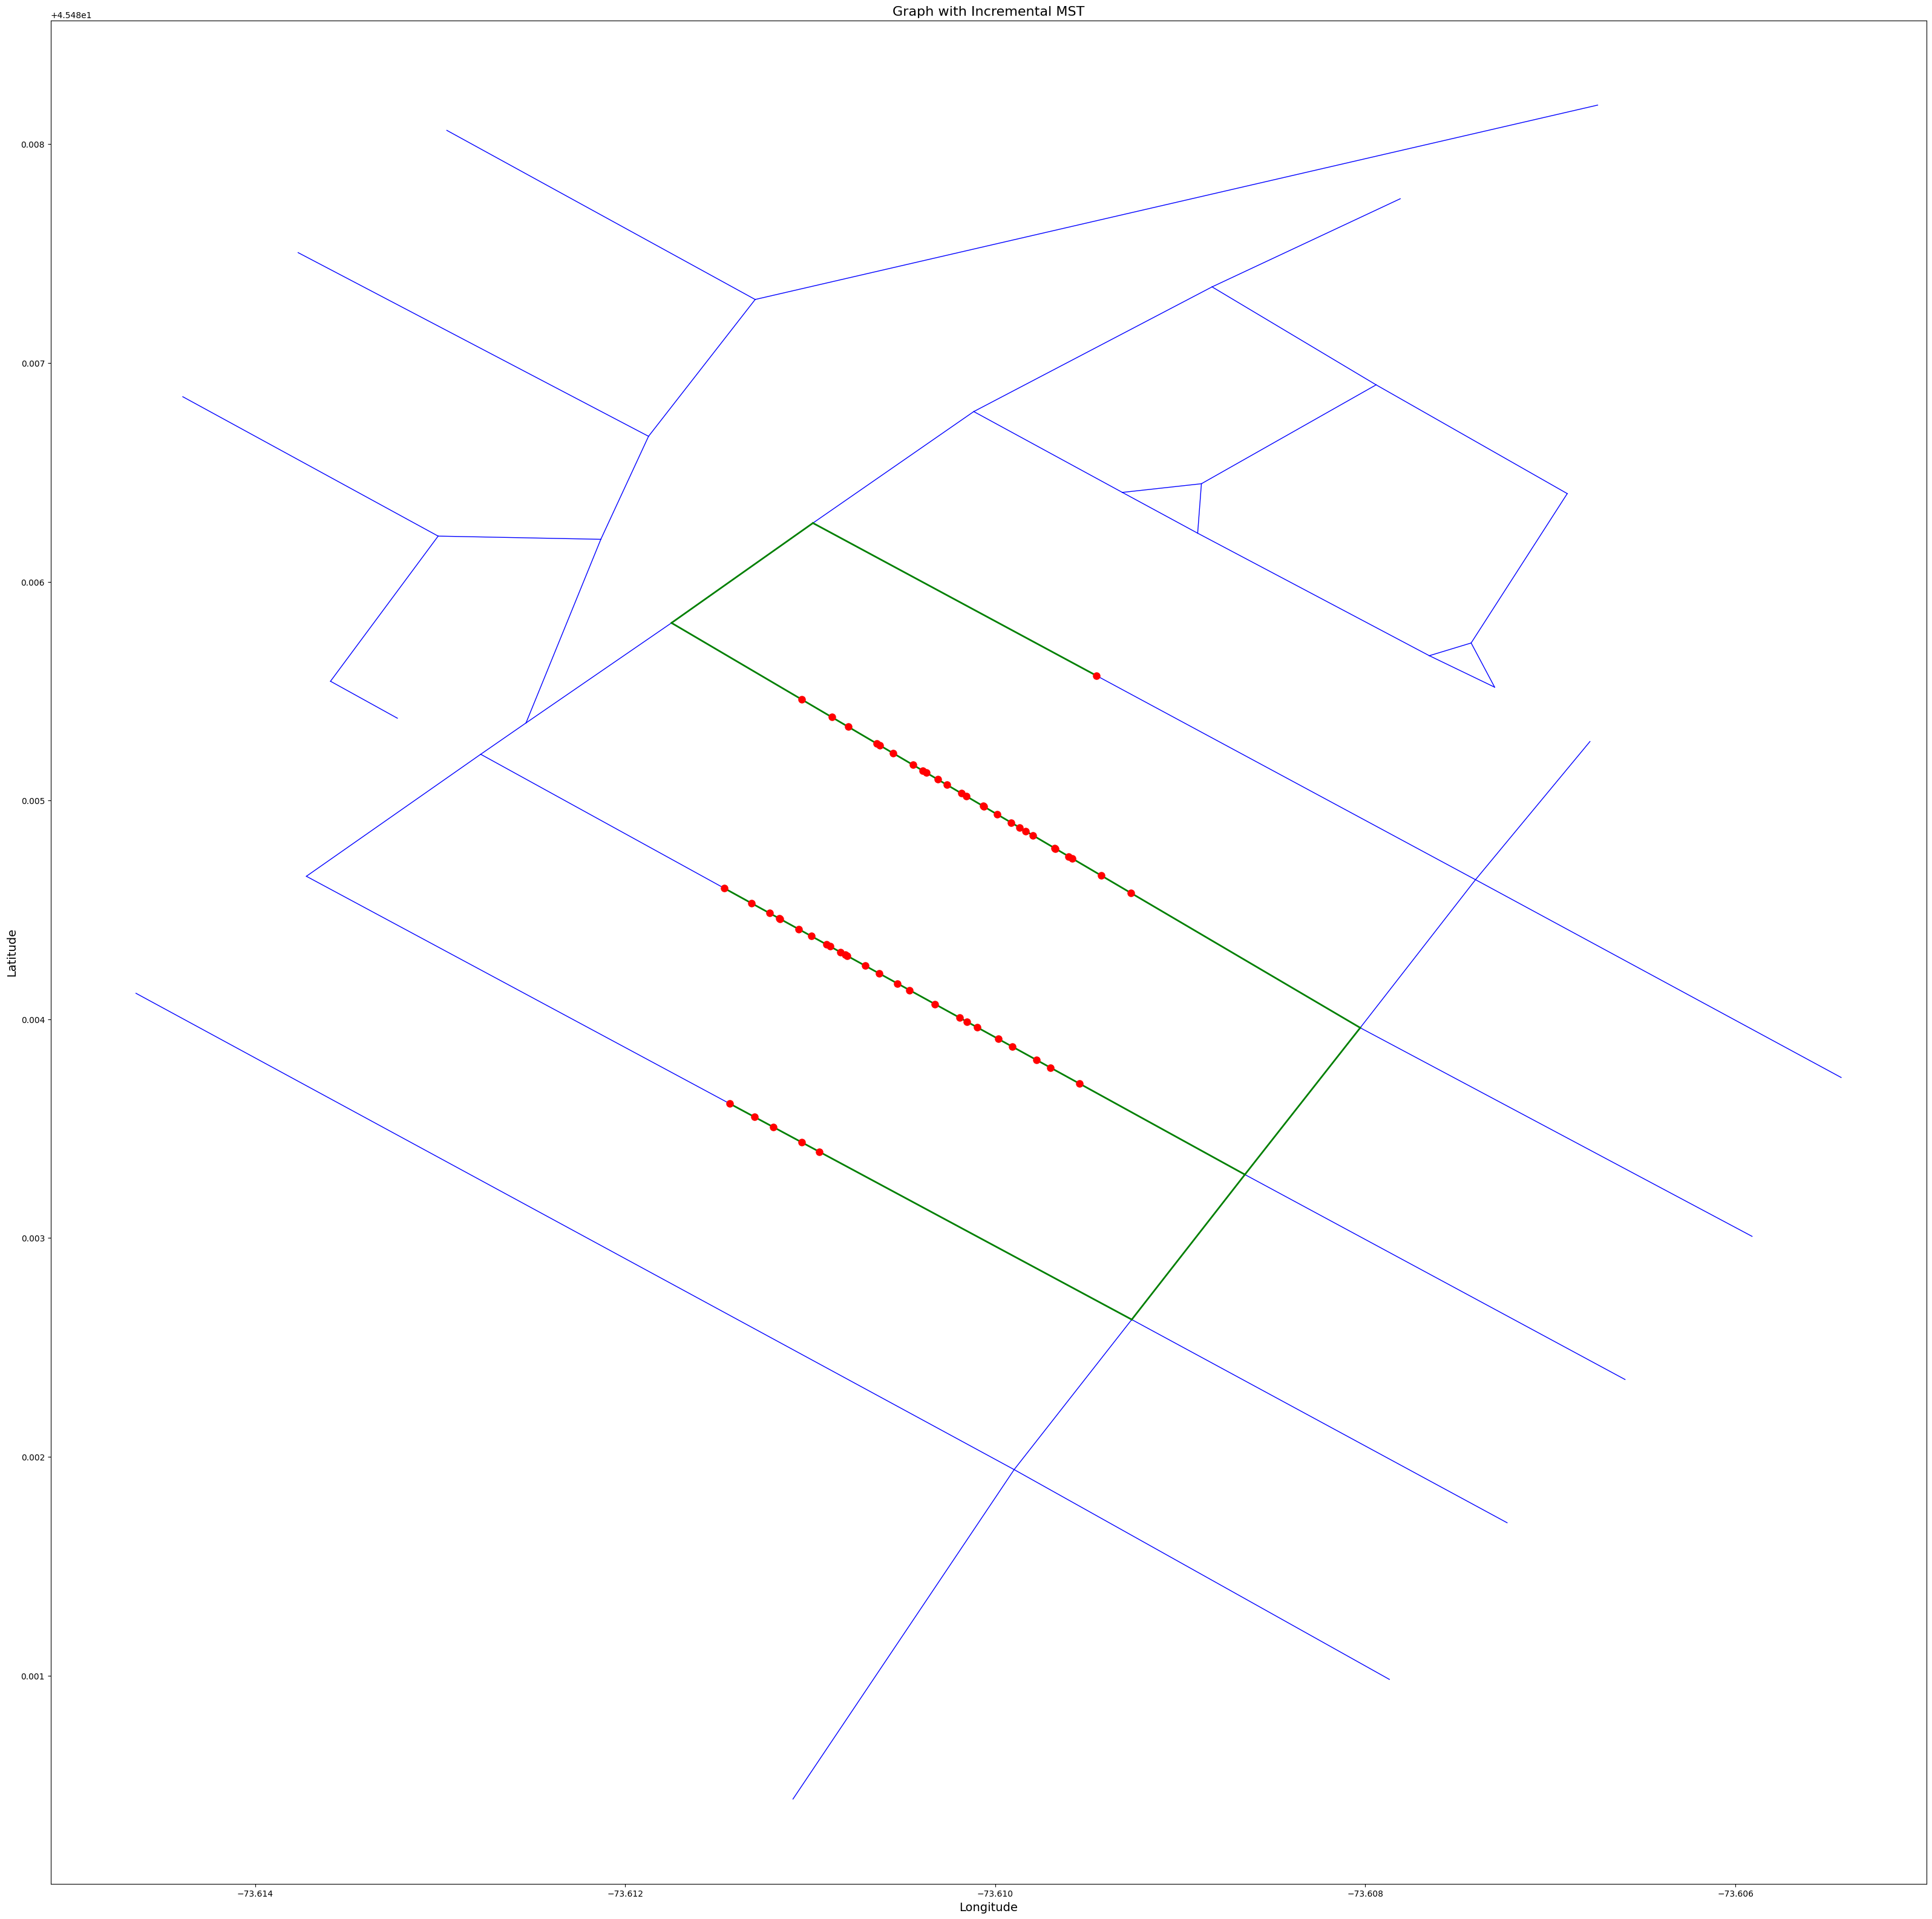

In [39]:
import heapq
G = nx.Graph()

# Add edges to the graph from the cleaned lines
for line in cleaned_lines:
    coords = list(line.coords)
    for i in range(len(coords) - 1):
        G.add_edge(coords[i], coords[i + 1], weight=Point(coords[i]).distance(Point(coords[i + 1])))

# Function to find the paths between nearest points
def find_paths_between_nearest_points(G, nearest_points):
    edges = []
    for i, start_point in enumerate(nearest_points):
        start = (start_point.x, start_point.y)
        for end_point in nearest_points[i+1:]:
            end = (end_point.x, end_point.y)
            if nx.has_path(G, start, end):
                path = nx.shortest_path(G, source=start, target=end, weight='weight')
                path_edges = list(zip(path[:-1], path[1:]))
                edges.extend((u, v, G[u][v]['weight']) for u, v in path_edges)
    return edges

# Find the edges used to connect the nearest points
edges = find_paths_between_nearest_points(G, nearest_points)

# Create a graph from these edges
H = nx.Graph()
H.add_weighted_edges_from(edges)

# Compute the Minimum Spanning Tree (MST) using Kruskal's algorithm
mst = nx.minimum_spanning_tree(H, weight='weight')

# Perform pathfinding again on the MST to ensure shortest paths within the MST
final_edges = []
for u, v in mst.edges():
    if nx.has_path(G, u, v):
        path = nx.shortest_path(G, source=u, target=v, weight='weight')
        path_edges = list(zip(path[:-1], path[1:]))
        final_edges.extend((x, y, G[x][y]['weight']) for x, y in path_edges)

# Create the final MST graph with these edges
final_mst = nx.Graph()
final_mst.add_weighted_edges_from(final_edges)

# Identify and iteratively remove edges that do not have any nearest points and have one end with only one connection
nearest_points_tuples = [(point.x, point.y) for point in nearest_points]

def find_edges_to_remove(graph):
    edges_to_remove = []
    for u, v in graph.edges():
        if u not in nearest_points_tuples and v not in nearest_points_tuples:
            if graph.degree(u) == 1 or graph.degree(v) == 1:
                edges_to_remove.append((u, v))
    return edges_to_remove

edges_to_remove = find_edges_to_remove(final_mst)

while edges_to_remove:
    final_mst.remove_edges_from(edges_to_remove)
    edges_to_remove = find_edges_to_remove(final_mst)

# Function to generate a random color
def random_color():
    return "#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])

# Function to plot the graph with MST
# Function to plot the graph with MST
def plot_graph(G, mst, nearest_points):
    fig, ax = plt.subplots(figsize=(40, 40))  # Increase the figure size

    pos = {node: node for node in G.nodes()}

    # Plot the graph edges
    for (u, v) in G.edges():
        x = [u[0], v[0]]
        y = [u[1], v[1]]
        ax.plot(x, y, color='blue', linewidth=1)

    # Plot the MST edges
    for (u, v) in mst.edges():
        x = [u[0], v[0]]
        y = [u[1], v[1]]
        ax.plot(x, y, color='green', linewidth=2)  # Plot MST edges in green

    # Plot the nearest points
    for point in nearest_points:
        ax.plot(point.x, point.y, 'ro', markersize=8)  # 'ro' for red circles, increase marker size

    ax.set_title('Graph with Incremental MST', fontsize=16)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    plt.show()

# Plot the graph and MST
plot_graph(G, final_mst, nearest_points)